In [1]:
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *
from mandel_runscript import make_model
import porepy as pp


model = make_model(
    {
        "physics": 1,
        "geometry": 0,
        "barton_bandis_stiffness_type": 2,
        "friction_type": 1,
        "grid_refinement": 1,
        "solver": 2,
    }
)
model.prepare_simulation()
model.before_nonlinear_loop()
model.before_nonlinear_iteration()
model.assemble_linear_system()
rhs = model.linear_system[1]

/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore




Sim time: 0.0, Dt: 0.50 (days)
sticking: 9, sliding: 0, open: 0


In [2]:
mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(
    load_data(f"../stats/{model.simulation_name()}.json"), 10
)
model.linear_system = mat, rhs
model.bmat.mat = mat

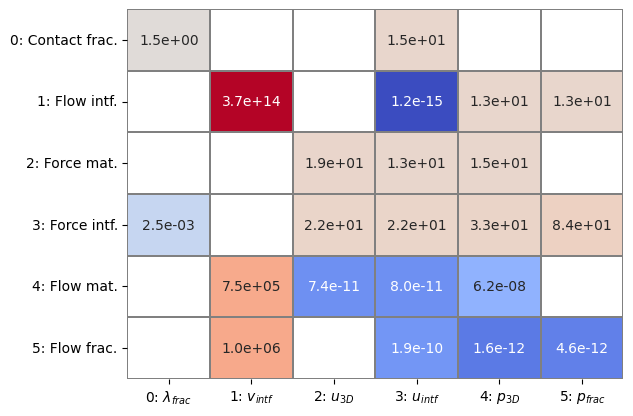

In [3]:
J = model.bmat[:]
J.plot_max()

Construction took: 0.42
Solve  took: 0.03
True residual: 6.537879578116903e-10
PETSc Converged Reason: 2


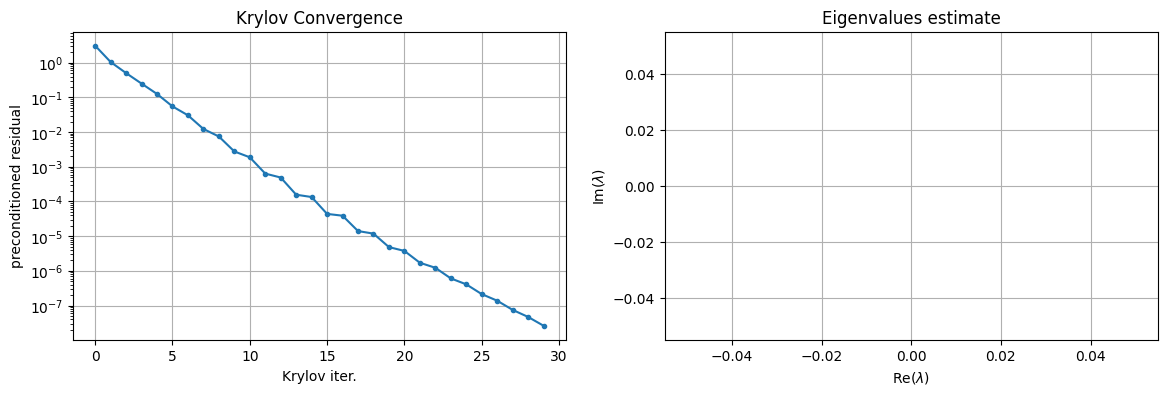

In [56]:
from fixed_stress import make_fs_analytical, make_fs_analytical_slow
from hm_solver import build_mechanics_near_null_space
from mat_utils import *
from block_matrix import *

solve_petsc_3(
    J,
    rhs_global=rhs,
    ksp_scheme=KSPScheme(
        ksp="richardson",
        rtol=1e-8,
        right_transformations=[
            lambda bmat: model.Qright(contact_group=0, u_intf_group=3)
        ],
        preconditioner=FieldSplitScheme(
            groups=[0],
            solve=lambda bmat: inv_block_diag(mat=bmat[[0]].mat, nd=model.nd),
            # invertor_type="operator",
            # invertor=lambda bmat: make_stabilizer(bmat).mat,
            complement=FieldSplitScheme(
                groups=[1],
                solve=lambda bmat: PetscILU(bmat[[1]].mat),
                invertor=lambda bmat: extract_diag_inv(bmat[[1]].mat),
                complement=FieldSplitScheme(
                    groups=[2, 3],
                    solve=lambda bmat: PetscAMGMechanics(
                        mat=bmat[[2, 3]].mat,
                        dim=model.nd,
                        null_space=build_mechanics_near_null_space(model),
                    ),
                    invertor_type="physical",
                    invertor=lambda bmat: make_fs_analytical(
                        model, bmat, p_mat_group=4, p_frac_group=5
                    ).mat
                    # * 0,
                    # * 0.5,
                    * 1,
                    complement=FieldSplitScheme(
                        groups=[4, 5],
                        solve=lambda bmat: PetscAMGFlow(
                            mat=bmat[[4, 5]].mat, dim=model.nd
                        ),
                    ),
                ),
            ),
        ),
    ),
)

all: 11
none: 16
only_mat: 11
only_frac: 16

Solve  took: 0.23
True residual: 1.2457693417389754e-14
PETSc Converged Reason: 2
Error in callback <function _draw_all_if_interactive at 0x761a70380ae0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

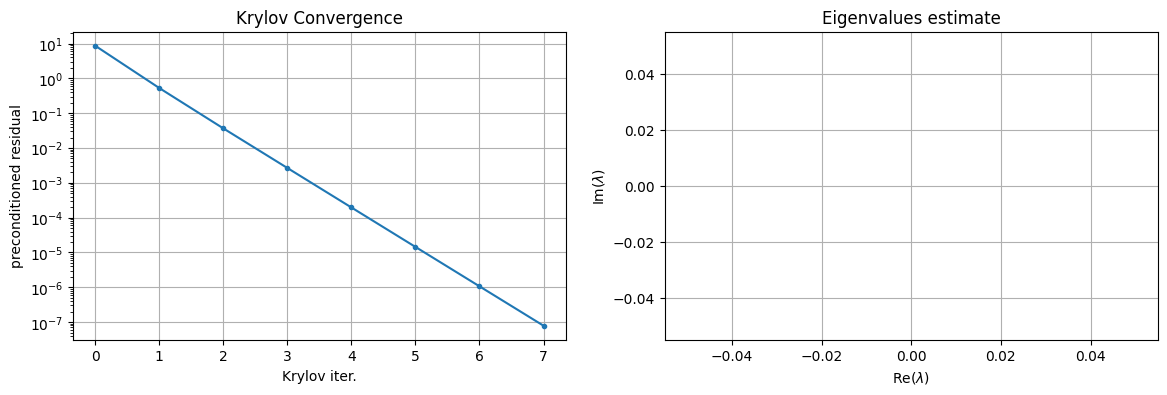

In [ ]:
from fixed_stress import make_fs_analytical
from hm_solver import build_mechanics_near_null_space
from mat_utils import *
from block_matrix import *

solve_petsc_3(
    J,
    rhs_global=rhs,
    ksp_scheme=KSPScheme(
        ksp="richardson",
        rtol=1e-8,
        # right_transformations=[
        #     lambda bmat: model.Qright(contact_group=0, u_intf_group=3)
        # ],
        preconditioner=FieldSplitScheme(
            # Exactly solve elasticity and contact mechanics, build fixed stress.
            groups=[1],
            complement=FieldSplitScheme(
                groups=[0, 2, 3],
                invertor=lambda bmat: make_fs_analytical(
                    model, bmat, p_mat_group=4, p_frac_group=5
                ).mat
                * 1,
                invertor_type="physical",
                complement=FieldSplitScheme(
                    groups=[4, 5],
                ),
            ),
        ),
    ),
)

Solve  took: 0.47
True residual: 1.2595284410140698e-14
PETSc Converged Reason: 2


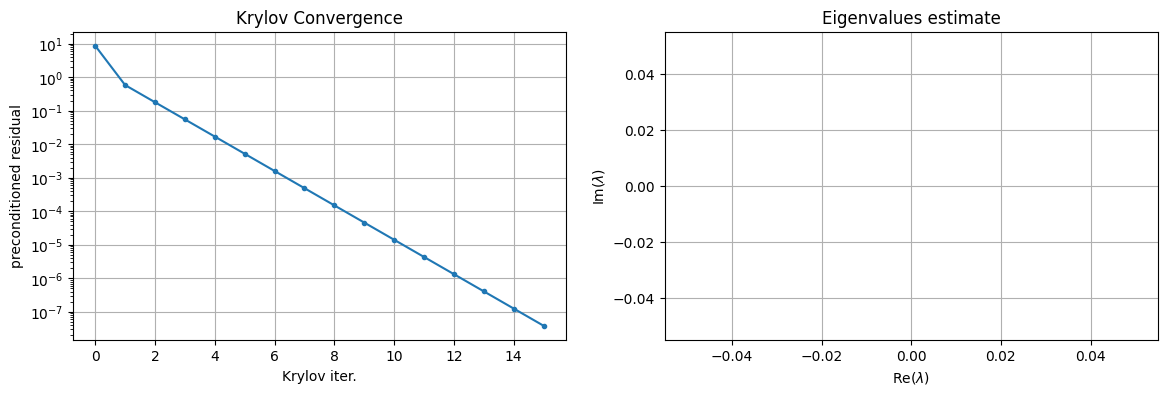

In [ ]:
from fixed_stress import make_fs_analytical
from hm_solver import build_mechanics_near_null_space
from mat_utils import *
from block_matrix import *

solve_petsc_3(
    J,
    rhs_global=rhs,
    ksp_scheme=KSPScheme(
        ksp="richardson",
        rtol=1e-8,
        right_transformations=[
            lambda bmat: model.Qright(contact_group=0, u_intf_group=3)
        ],
        preconditioner=FieldSplitScheme(
            # Exactly solve elasticity and contact mechanics, build fixed stress.
            groups=[1],
            complement=FieldSplitScheme(
                groups=[0, 2, 3],
                invertor=lambda bmat: make_fs_analytical(
                    model, bmat, p_mat_group=4, p_frac_group=5
                ).mat
                * 0,
                invertor_type="physical",
                complement=FieldSplitScheme(
                    groups=[4, 5],
                ),
            ),
        ),
    ),
)

Solve  took: 0.1
True residual: 4.296768917815867e-08
PETSc Converged Reason: 2


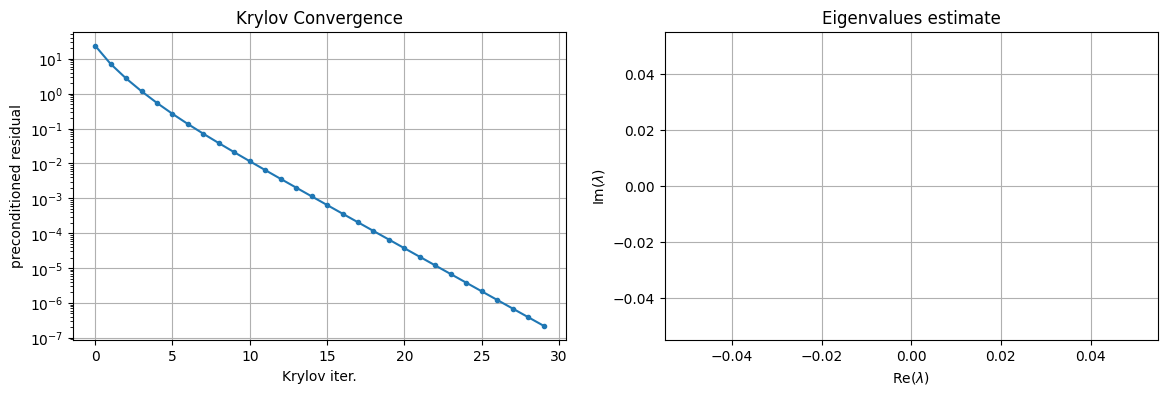

In [ ]:
from fixed_stress import make_fs_analytical
from hm_solver import build_mechanics_near_null_space
from mat_utils import *
from block_matrix import *

solve_petsc_3(
    J,
    rhs_global=rhs,
    ksp_scheme=KSPScheme(
        ksp="richardson",
        rtol=1e-8,
        preconditioner=FieldSplitScheme(
            groups=[2, 3],
            solve=lambda bmat: PetscAMGMechanics(
                mat=bmat[[2, 3]].mat,
                dim=model.nd,
                null_space=build_mechanics_near_null_space(model, include_intf=True),
            ),
        ),
    ),
)

In [89]:
pc = PetscAMGMechanics(
    mat=J[[2, 3]].mat,
    dim=model.nd,
    null_space=build_mechanics_near_null_space(model, include_intf=True),
)
pc.pc.view()

PC Object: 1 MPI process
  type: gamg
    type is MULTIPLICATIVE, levels=5 cycles=v
      Cycles per PCApply=1
      Using externally compute Galerkin coarse grid matrices
      GAMG specific options
        Threshold for dropping small values in graph on each level =   0.11   0.11   0.11   0.11   0.11  
        Threshold scaling factor for each level not specified = 1.
        AGG specific options
          Number of levels of aggressive coarsening 1
          Square graph aggressive coarsening
          Number smoothing steps 3
        Complexity:    grid = 1.41839    operator = 5.05832
  Coarse grid solver -- level 0 -------------------------------
    KSP Object: (mg_coarse_) 1 MPI process
      type: preonly
      maximum iterations=10000, initial guess is zero
      tolerances:  relative=1e-05, absolute=1e-50, divergence=10000.
      left preconditioning
      using NONE norm type for convergence test
    PC Object: (mg_coarse_) 1 MPI process
      type: bjacobi
        number of